# AUC Scoring Quirk

With Kaggle's AUC metric it is [impossible to score less than 0.25][2] - predictions with lower AUC than that are inverted with 1-score, so 0.2 becomes 0.8 and 0.1 shows as 0.9 etc.

This kernel selects all AUC competitions and plots every submission for each as Public LB vs Private LB score - these scores should be very correlated.

However - the plots have outliers: it seems the inversion is applied **separately** to public and private scores.

This means it is possible to score ~0.25 on one leaderboard and ~0.75 on the other.

Some of the competitions have a random public/private test set split - so it should not be possible to have such divergent scores. From a users' perspective, we submit one set of predictions, they should not be treated differently for each of the public/private subsets.

This has so far had a fairly small impact; competitions with top scores under 0.75 cannot be affected, but those with higher scores may be, and occasionally this has lead to large shake-up for individual teams (albeit in the bottom half of the LB).

If a competition with a score ceiling of 0.76 is launched it could cause a lot more confusion :)

It's most noticeable on the most recent AUC competition [IEEE-CIS Fraud Detection][1].

Kudos to Kaggle for making the raw data available to see this in such detail :)

### Color Scheme
 - gray: not used for either leaderboard
 - blue: used as public LB entry for team
 - red: used as private LB entry for team
 - purple: used as public and private LB entry for team
 
### Suggestions to Kaggle:
 - Invert both scores or neither.
 - Always inform the user whether the score is true or inverted.
 - Invert at 0.5 (some libraries do this).

Changing the threshold to 0.5 would potentially propel some teams from just over 0.25 to just under 0.75, slightly affecting ranking & points. Some stats are listed per competition to see the effect.

### Alternatively:
 - Do not invert at all, reject submissions with scores under 0.5
 - Do not invert at all, but warn participants to look at the bottom of the LB.
 - Do not invert scores, but add 'ghost' LB entries for submissions with low AUC, showing where they appear if inverted.
 
Are there other possibilities? Leave your comments below :)

 [1]: https://www.kaggle.com/c/ieee-fraud-detection
 [2]: https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19323
 

Competitions (43, 42)
Teams (252895, 12)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Submissions (985412, 11)


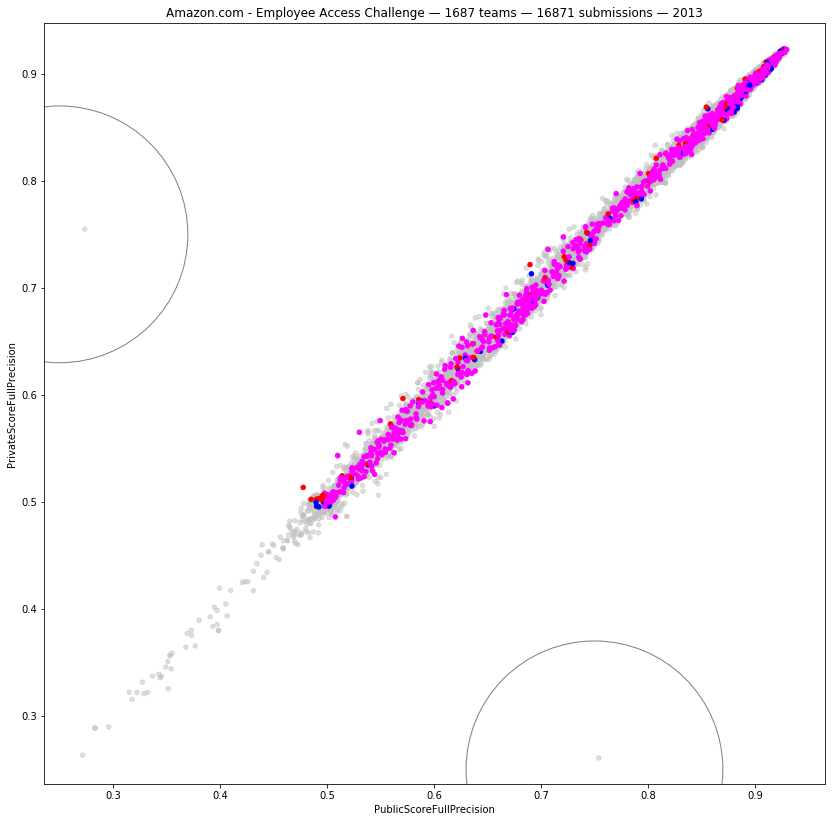

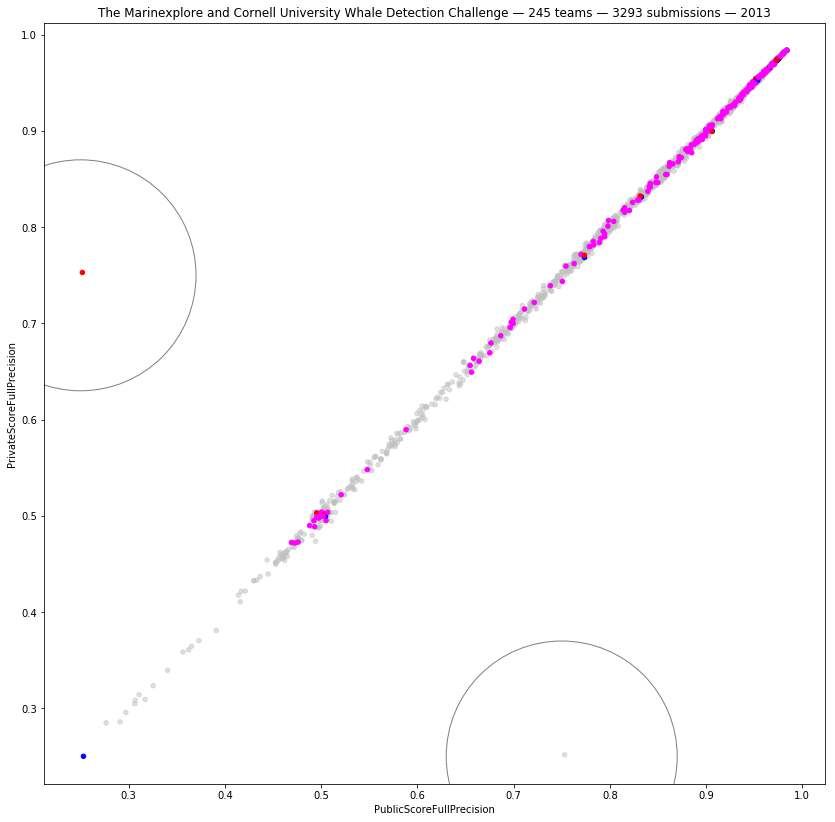

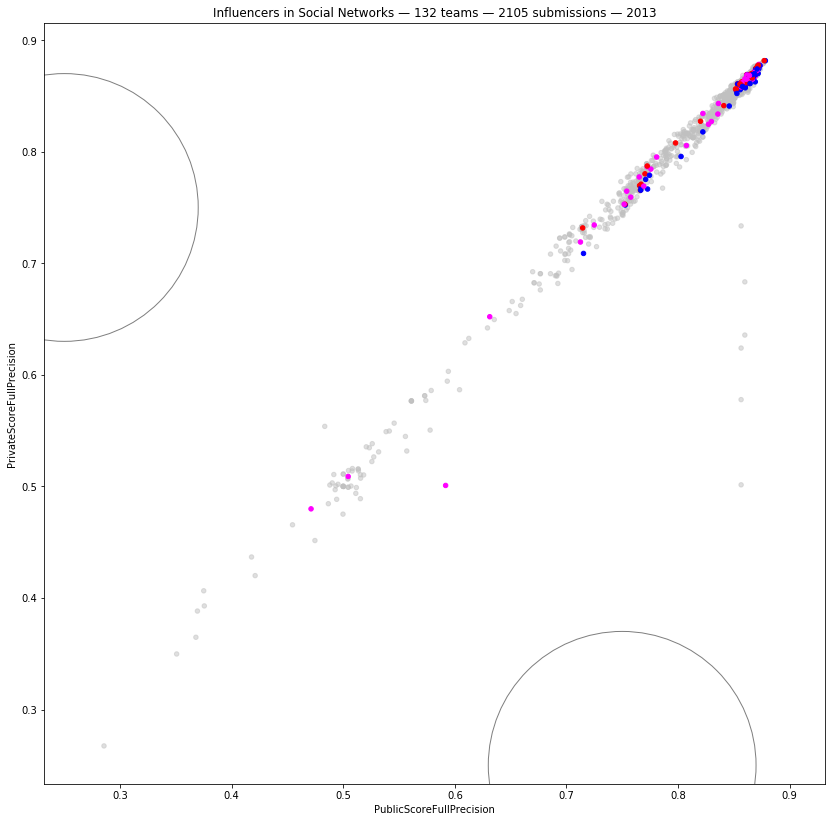

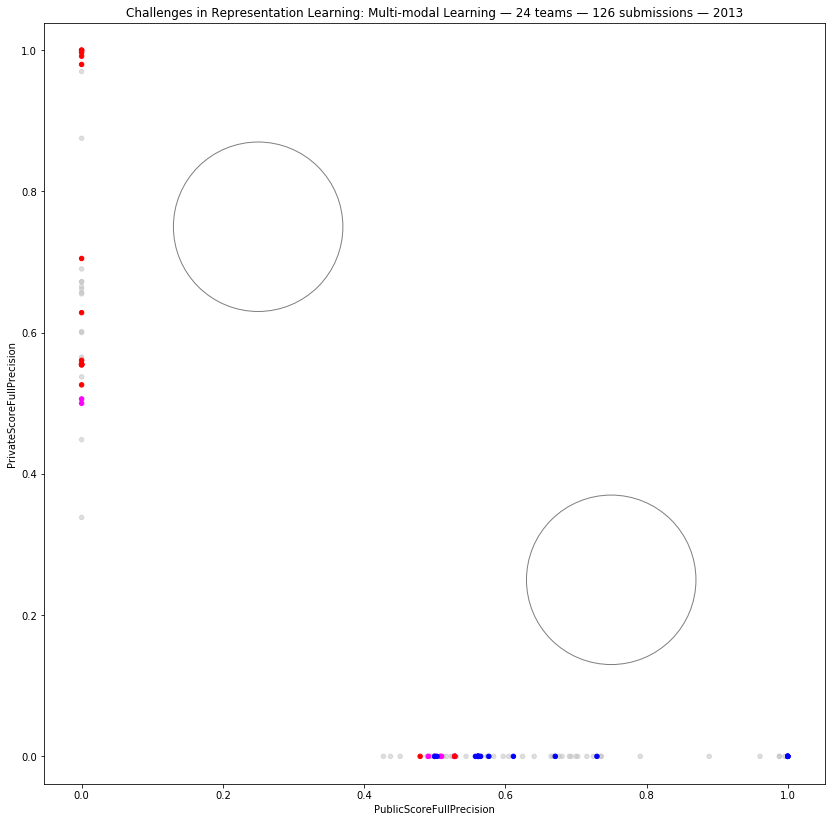

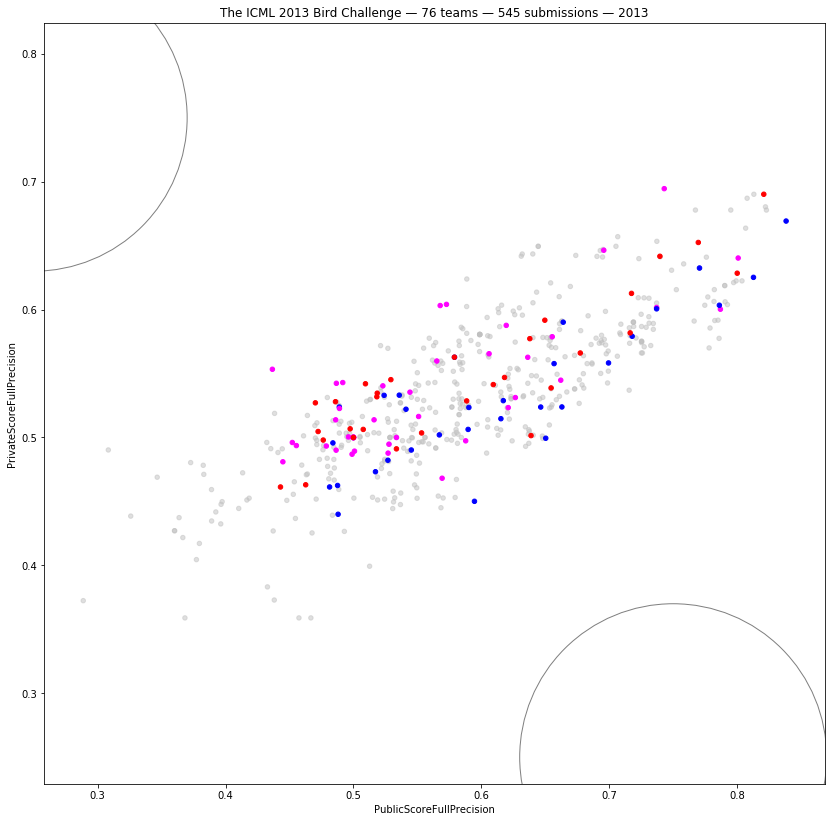

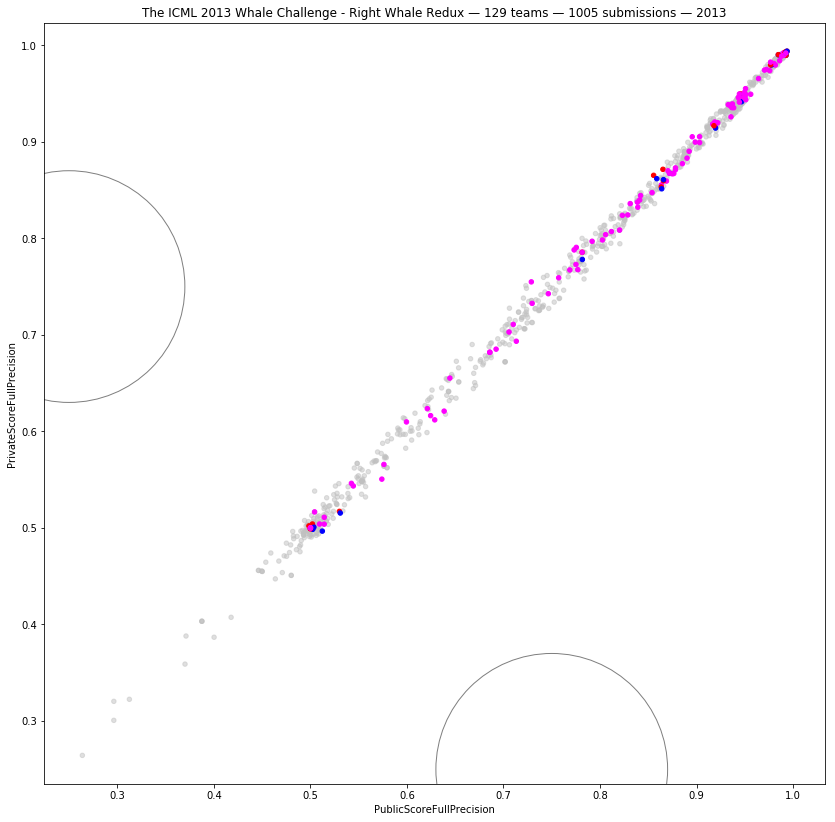

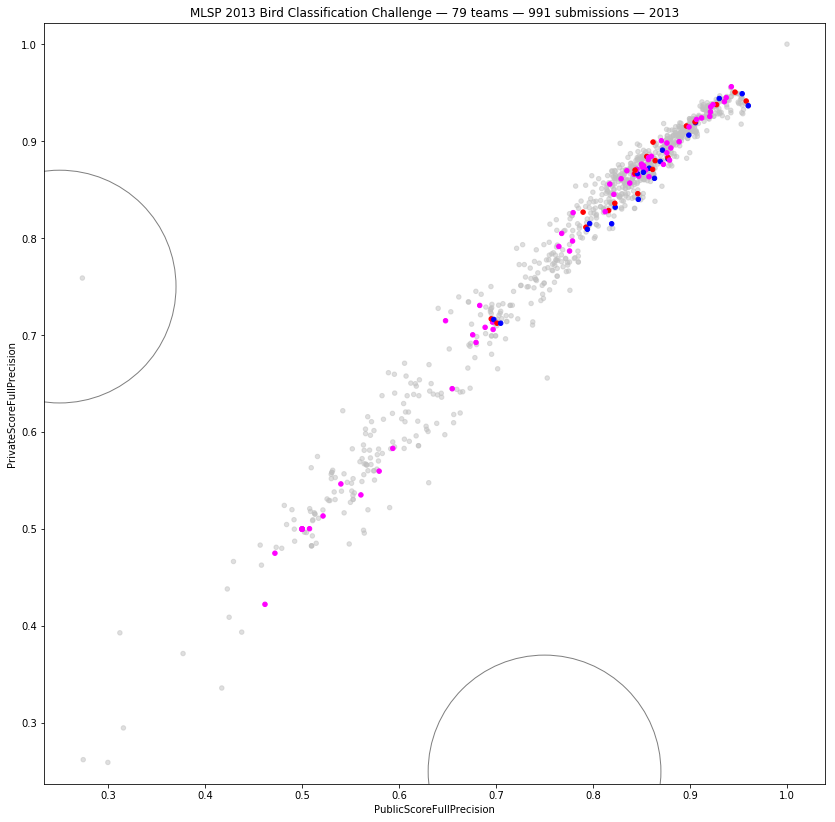

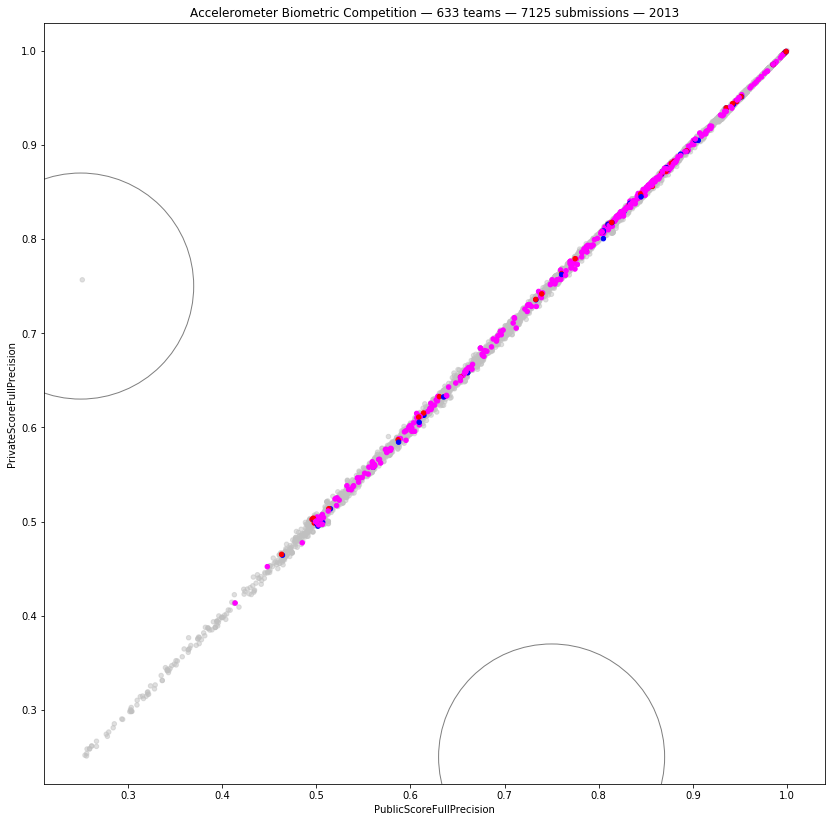

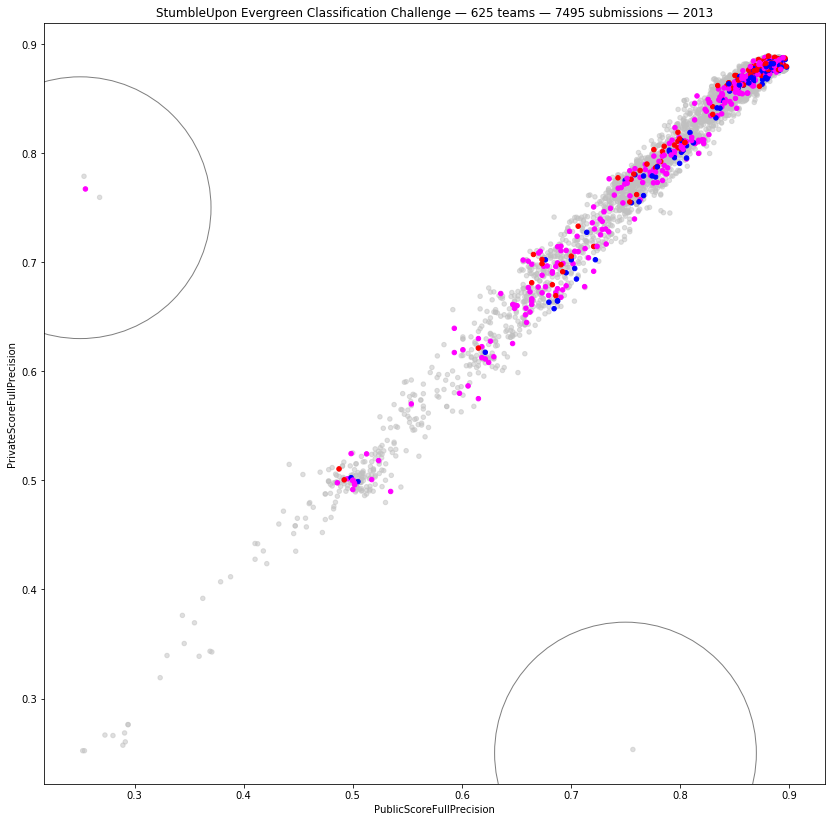

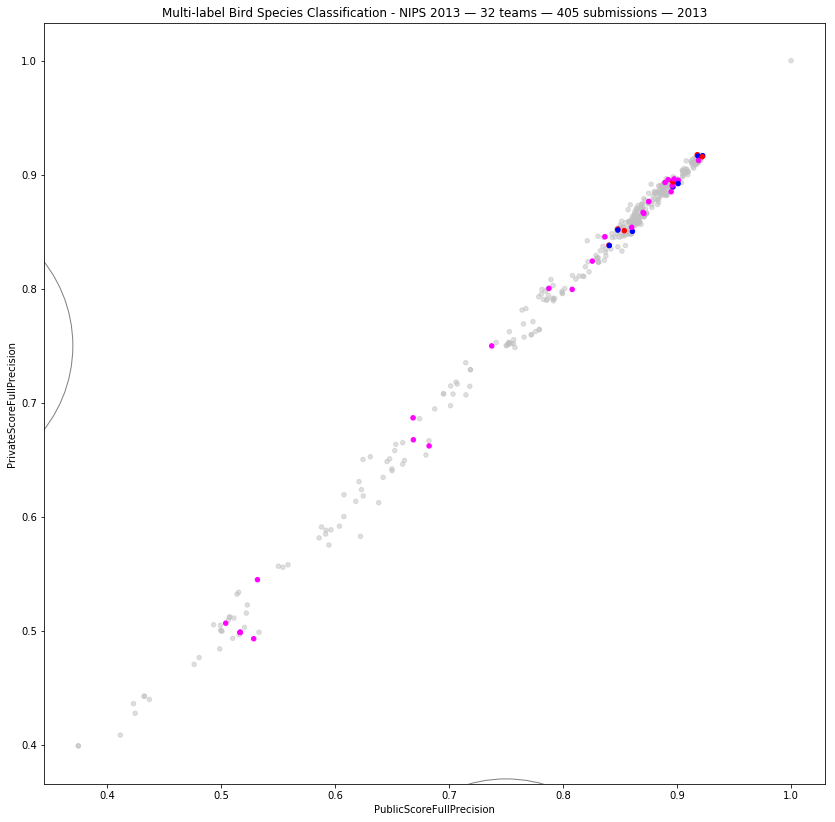

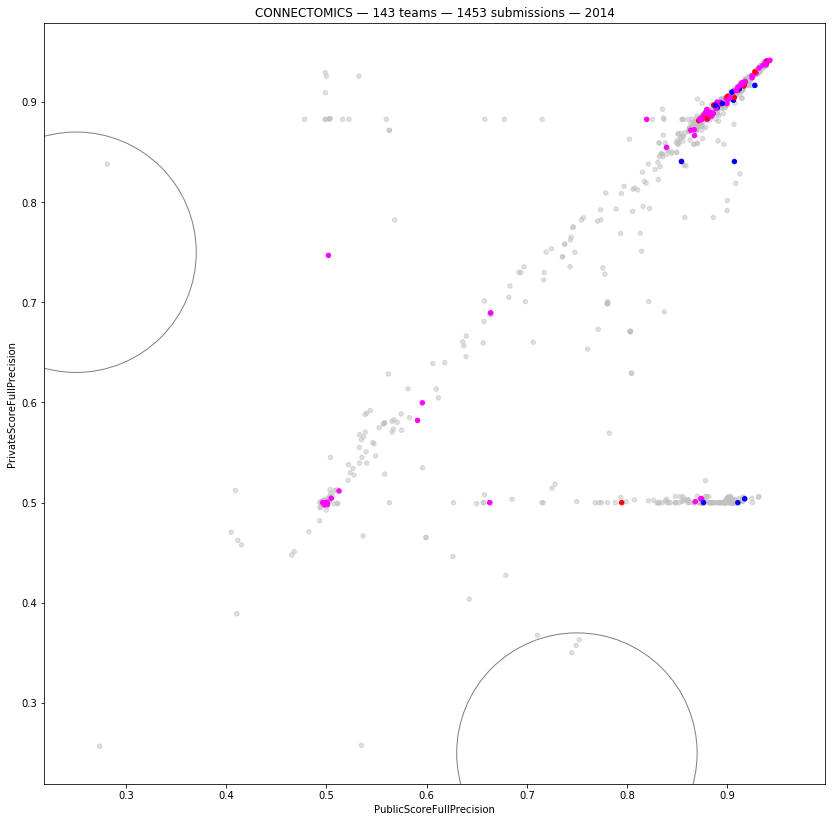

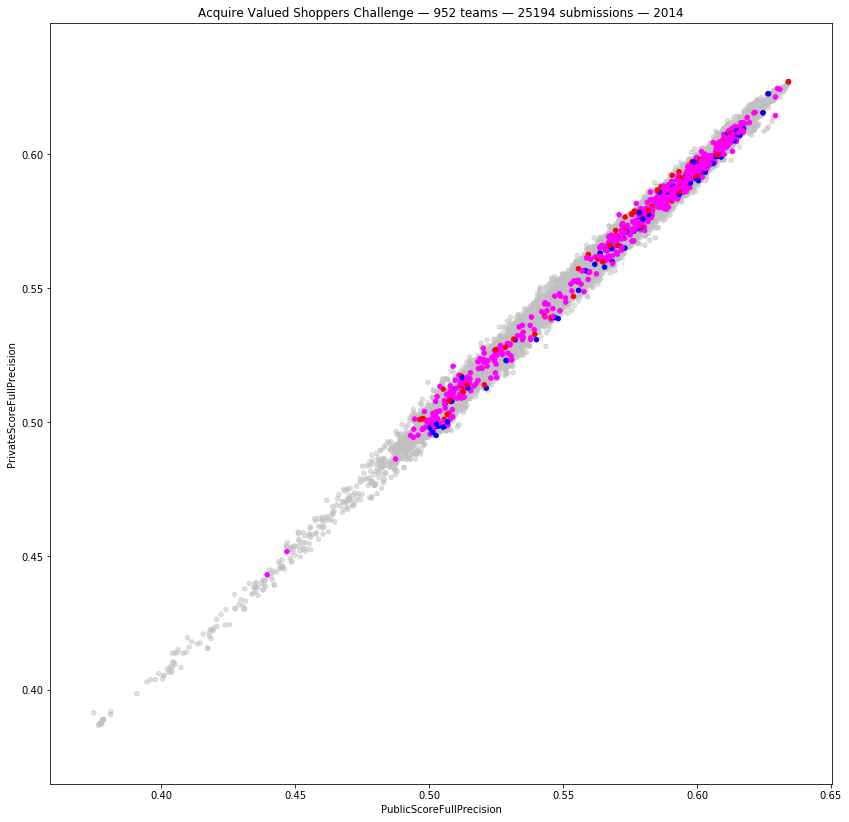

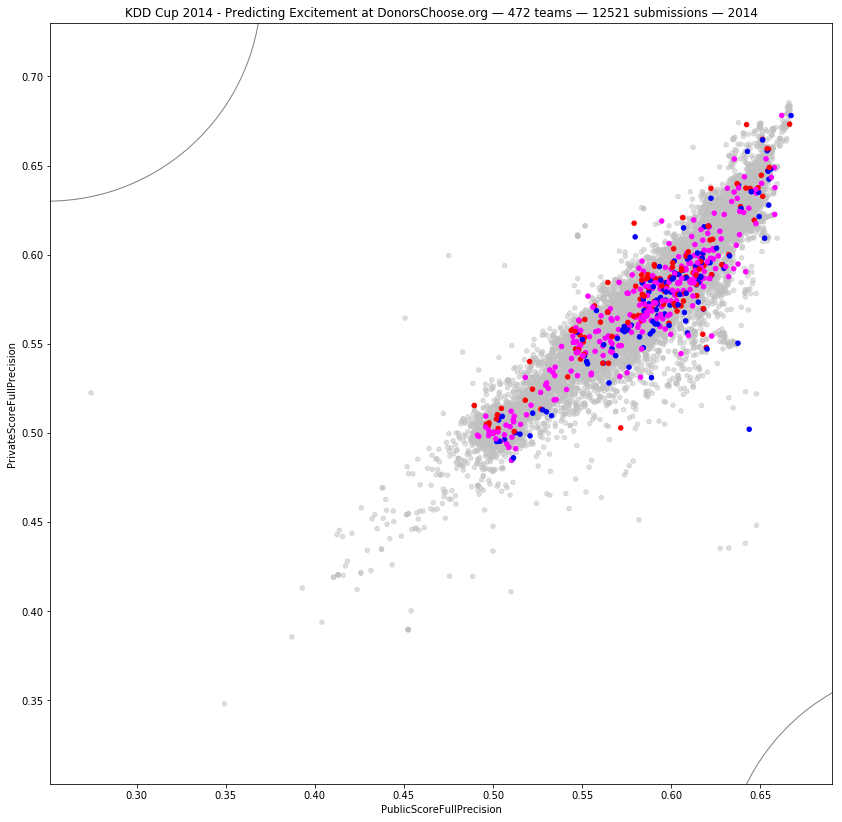

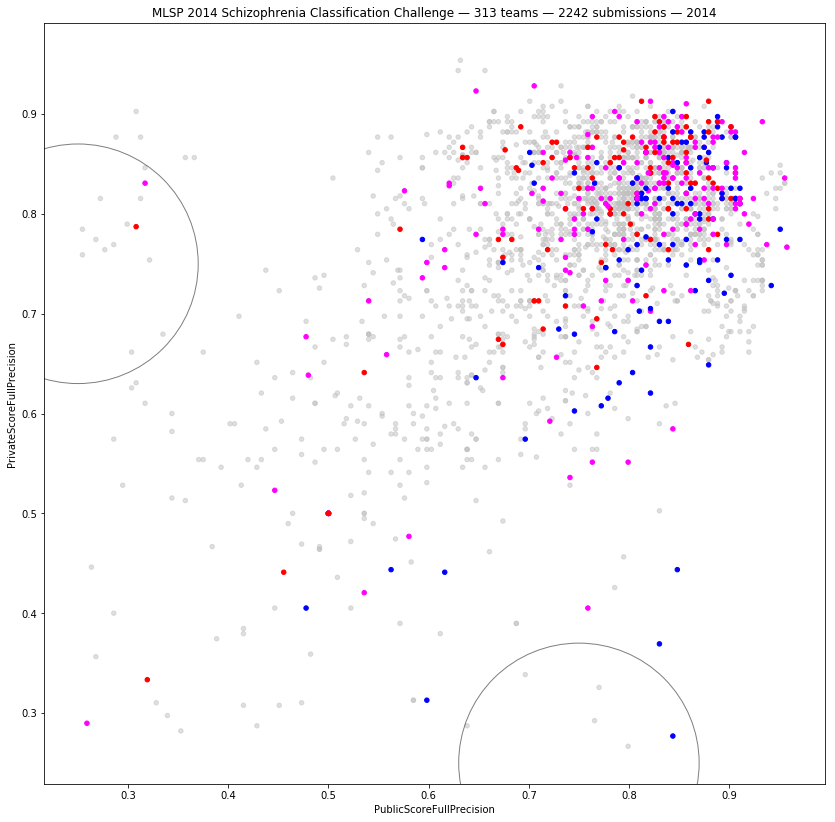

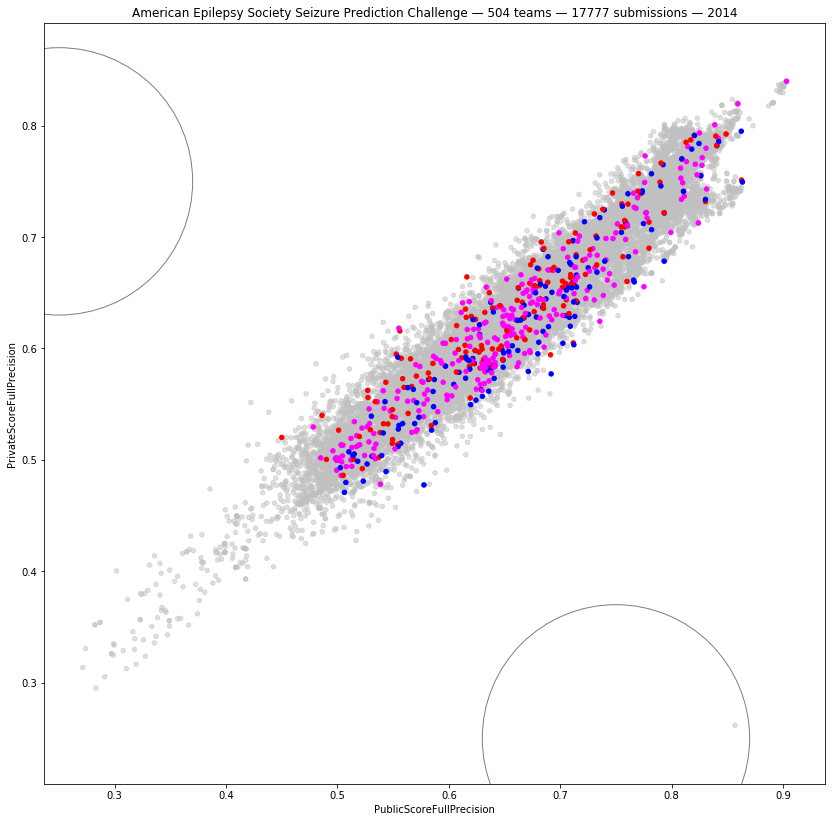

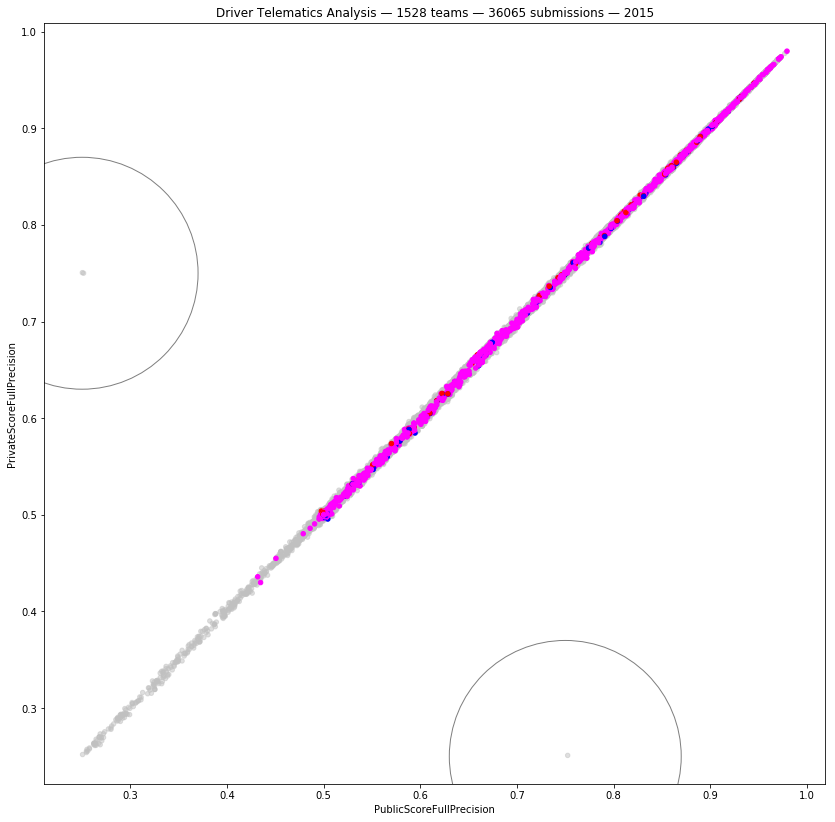

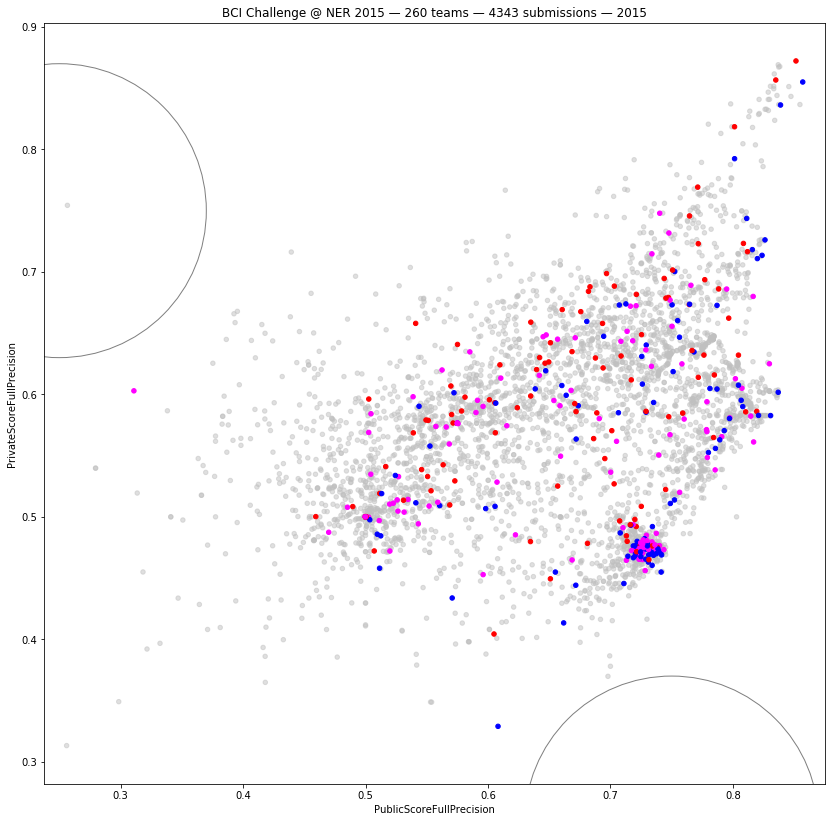

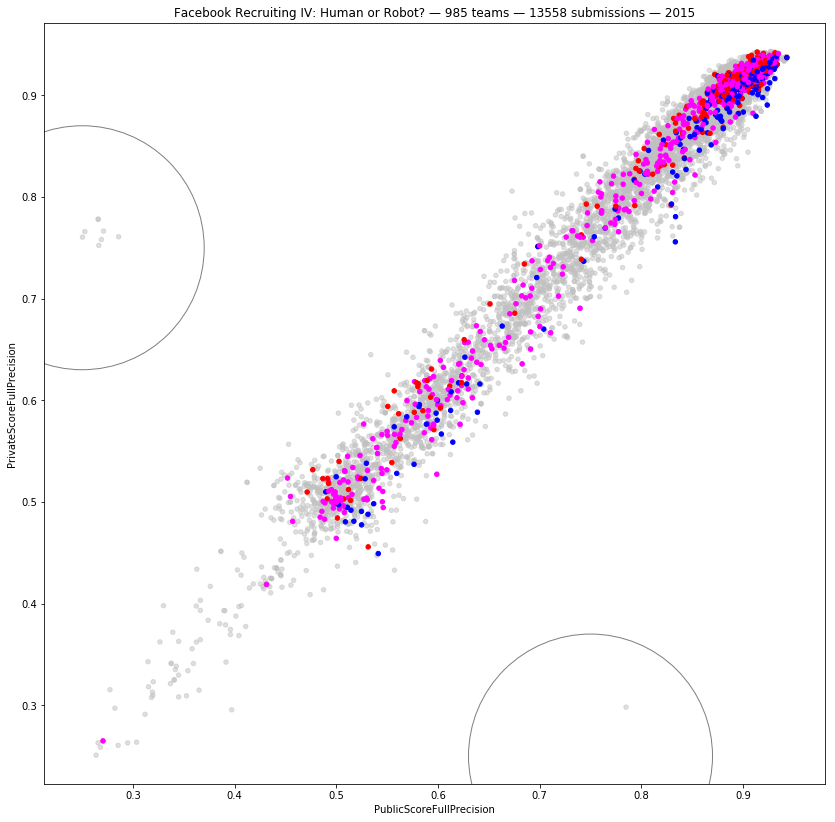

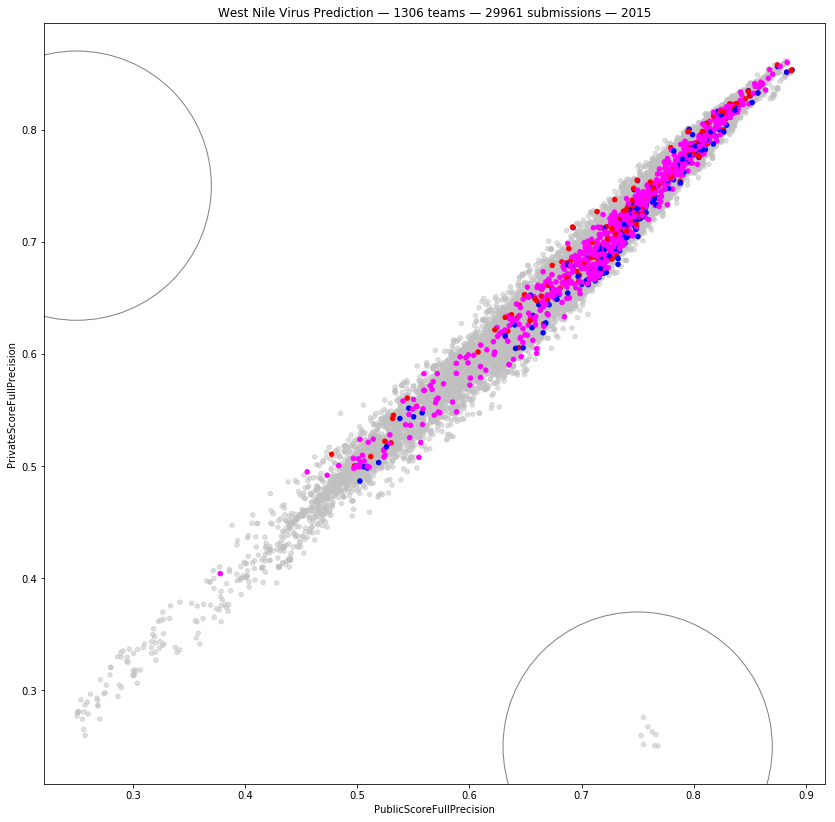

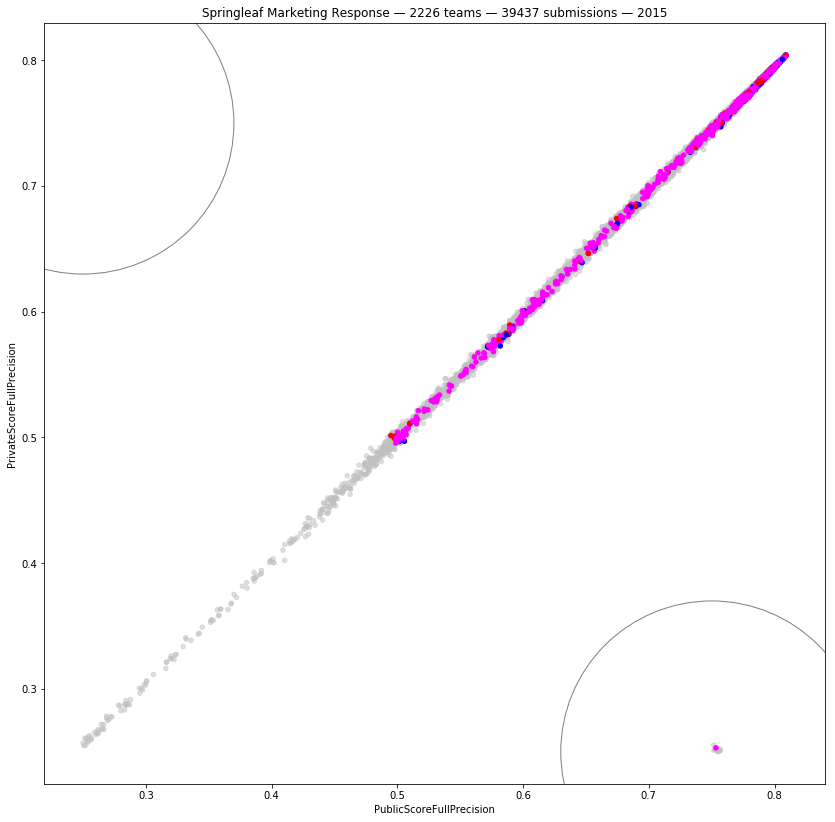

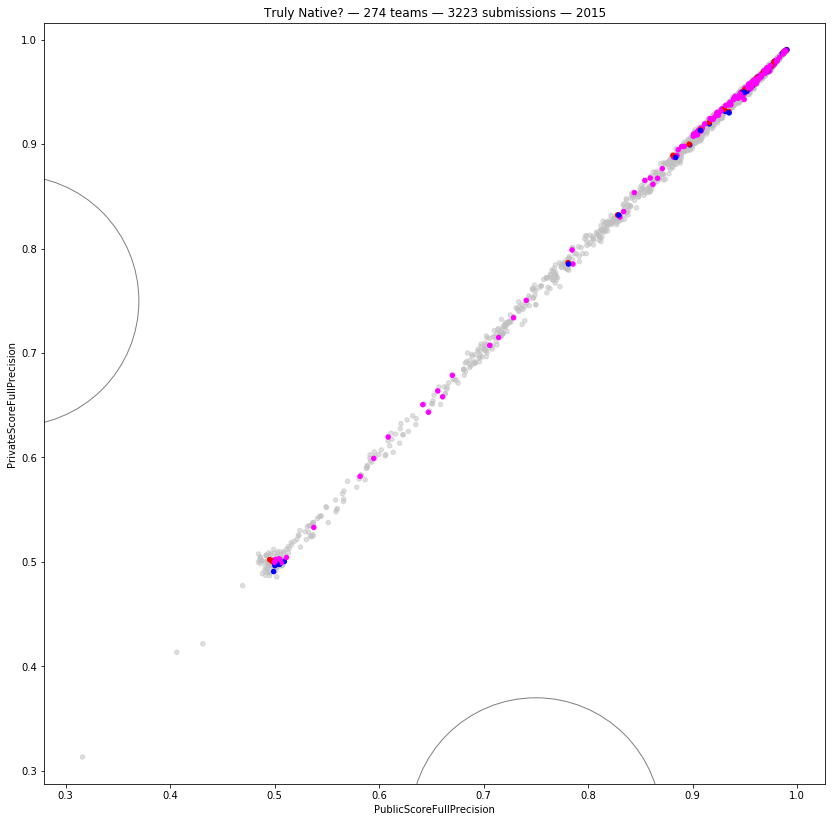

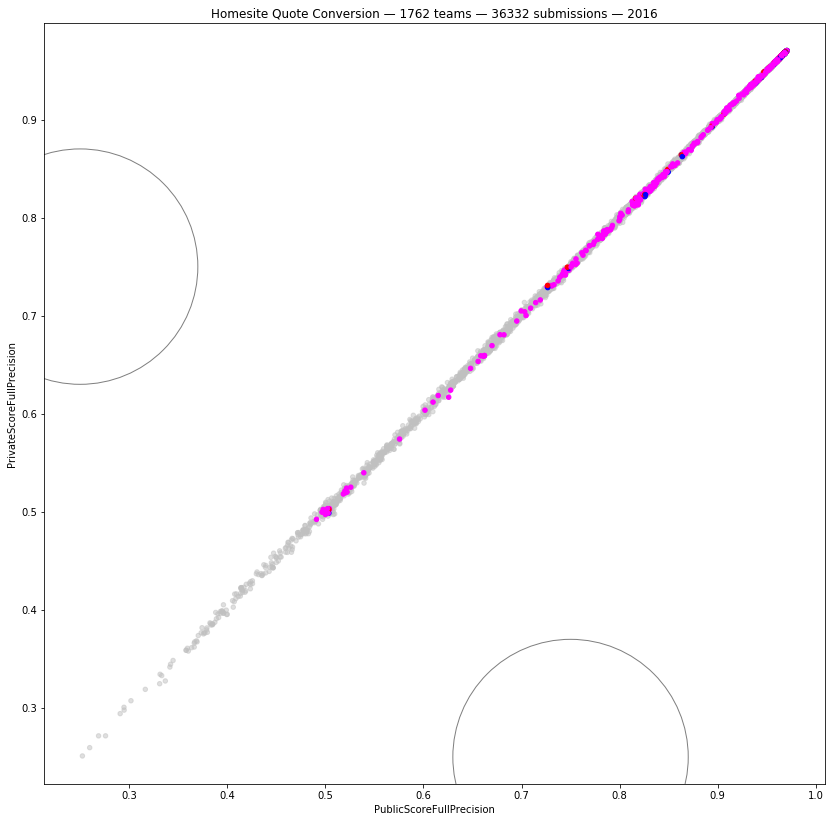

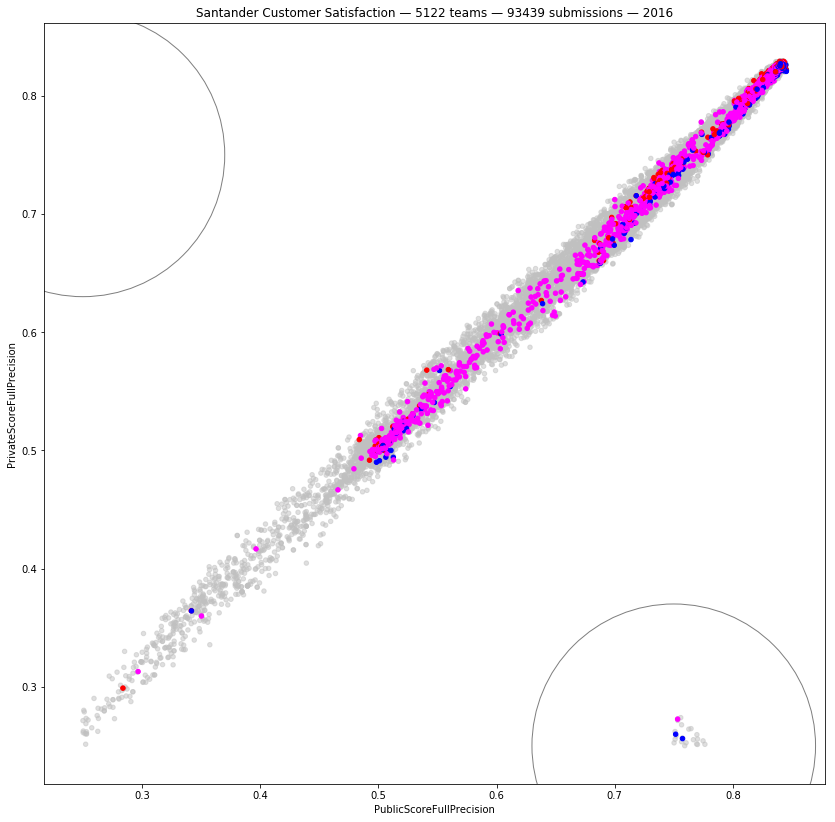

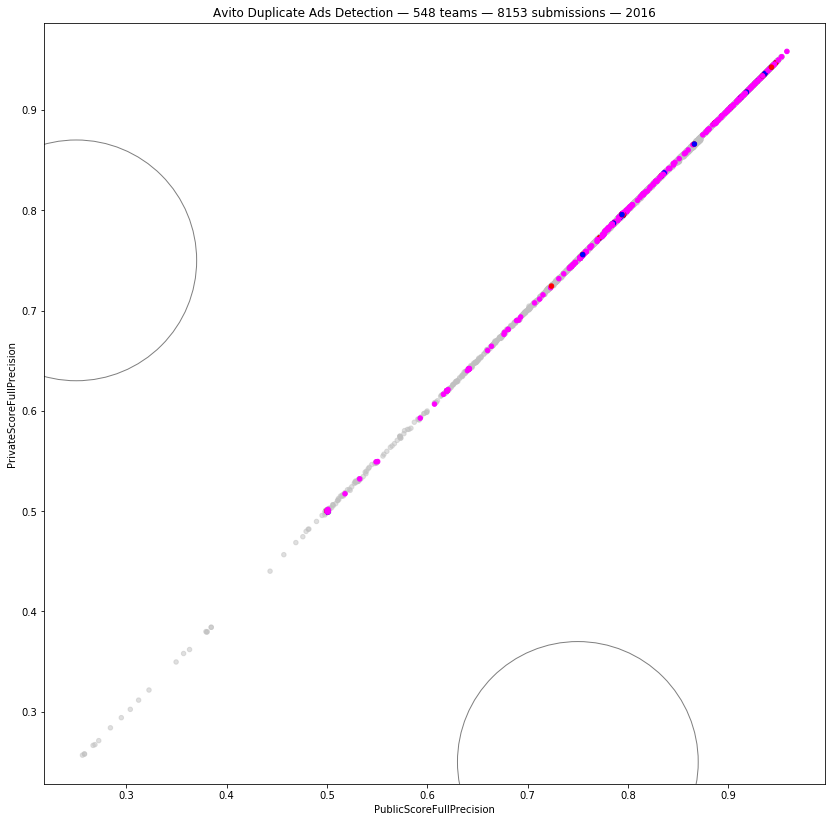

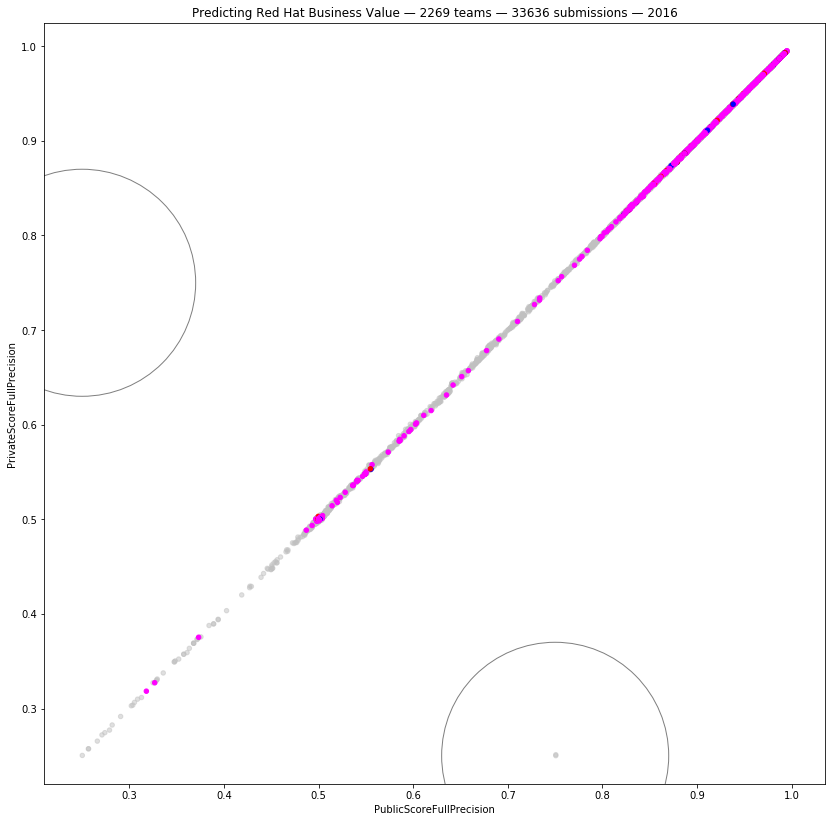

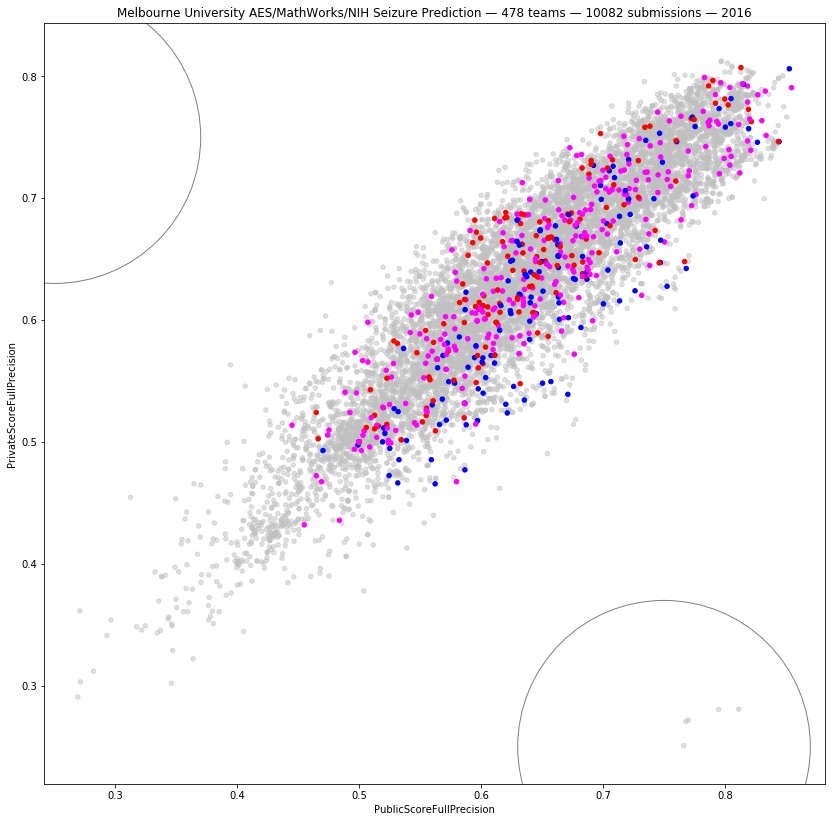

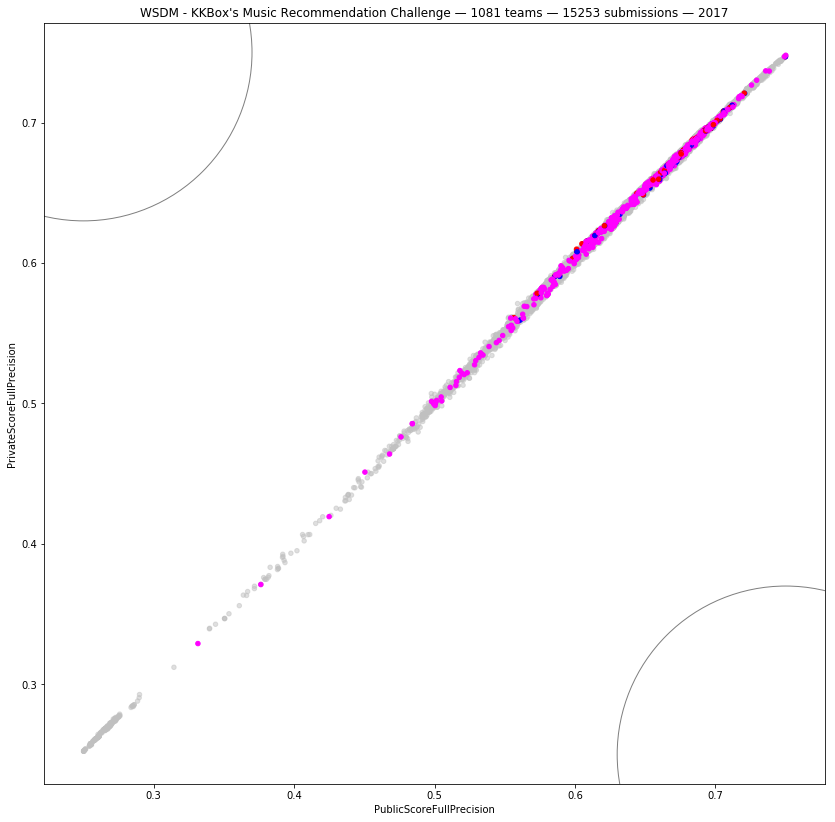

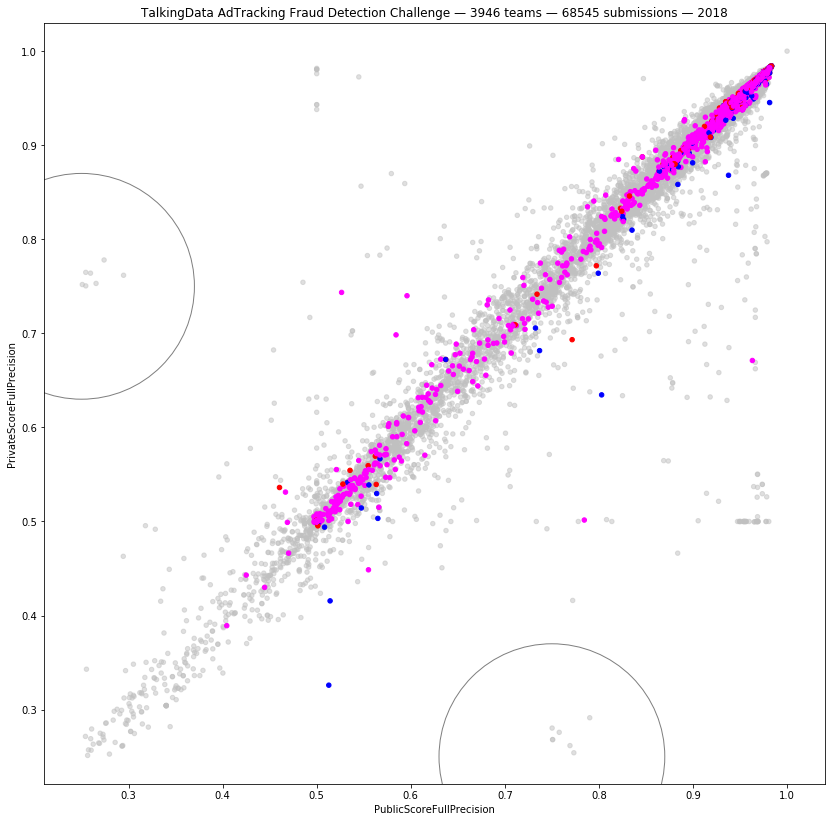

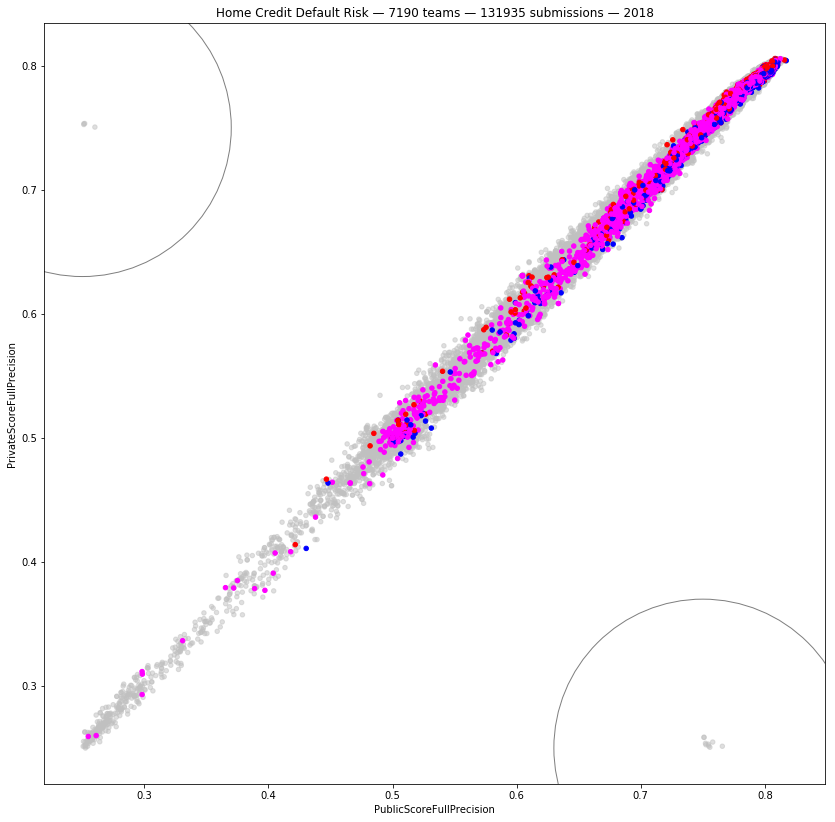

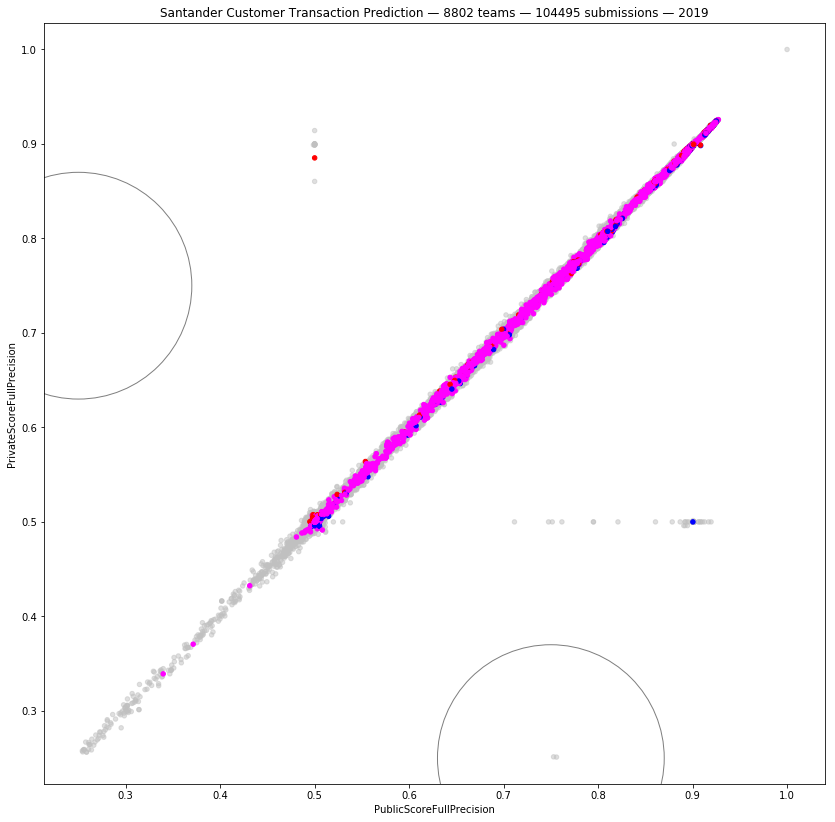

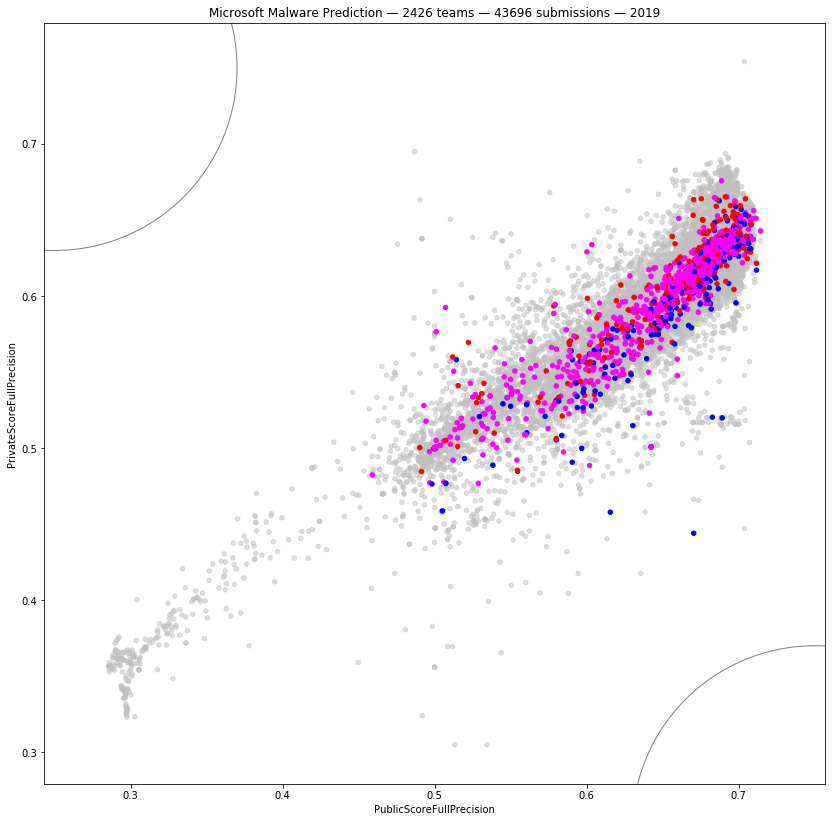

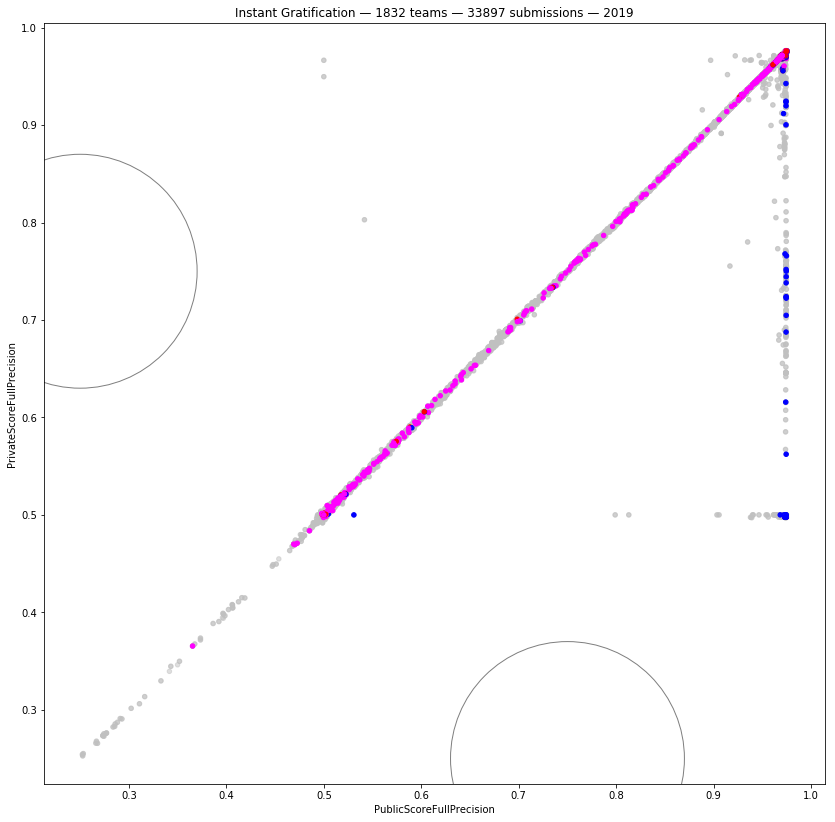

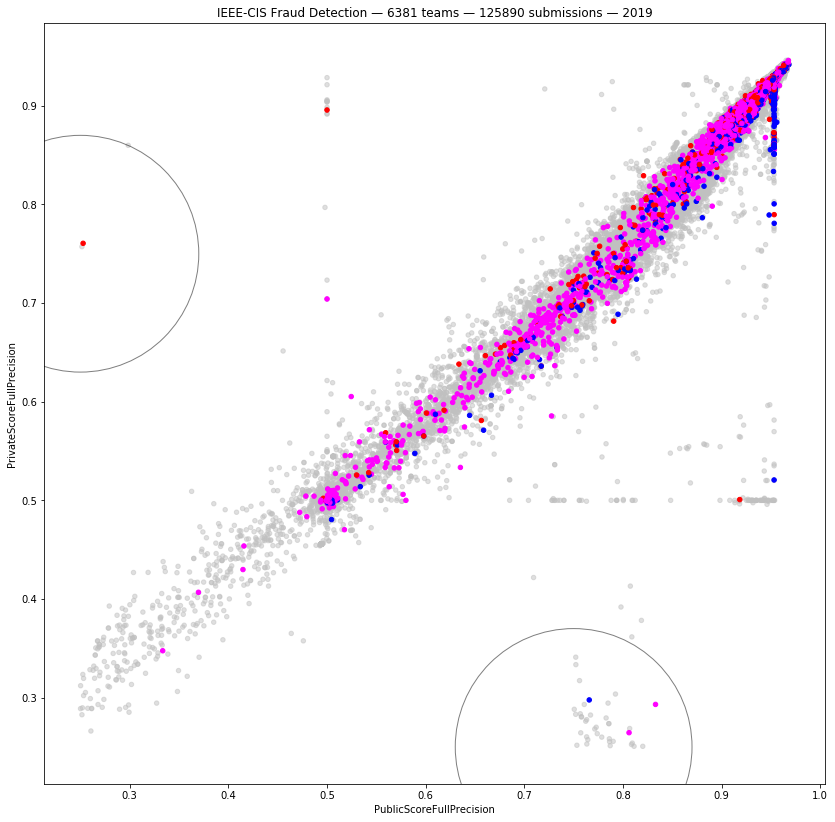

In [1]:
%matplotlib inline
import gc, os, sys, time
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from IPython.display import HTML, display

IN_DIR = '../input'
AUC = 'Area Under Receiver Operating Characteristic Curve'

def read_csv_filtered(csv, col, values, **kwargs):
    dfs = [df.loc[df[col].isin(values)]
           for df in pd.read_csv(f'{IN_DIR}/{csv}',
                                 chunksize=100000, **kwargs)]
    return pd.concat(dfs, axis=0)

TYPES = { 'Featured', 'Research', 'Recruitment' }

# Read Competitions
comps = read_csv_filtered('Competitions.csv', 'HostSegmentTitle', TYPES).set_index('Id')
idx = comps.EvaluationAlgorithmName.isnull()
comps.loc[idx, 'EvaluationAlgorithmName'] = comps.loc[idx, 'EvaluationAlgorithmAbbreviation']
comps['Year'] = pd.to_datetime(comps.DeadlineDate).dt.year
comps['RewardQuantity'].fillna('', inplace=True)

comps = comps.query('EvaluationAlgorithmName==@AUC', engine='python')
print("Competitions", comps.shape)

# Read Teams for those Competitions
asints = ['PublicLeaderboardSubmissionId',
           'PrivateLeaderboardSubmissionId']
DT = {c:'object' for c in asints}
teams = read_csv_filtered('Teams.csv', 'CompetitionId', comps.index, dtype=DT).set_index('Id')
teams[asints] = teams[asints].fillna(-1).astype(int)
print("Teams", teams.shape)

asfloats = ['PublicScoreLeaderboardDisplay',
            'PublicScoreFullPrecision',
            'PrivateScoreLeaderboardDisplay',
            'PrivateScoreFullPrecision',]

# Read Submissions for those Teams
subs = read_csv_filtered('Submissions.csv', 'TeamId', teams.index)
subs = subs.query('not IsAfterDeadline', engine='python')
subs[asfloats] = subs[asfloats].astype(float)
print("Submissions", subs.shape)

subs['CompetitionId'] = subs.TeamId.map(teams.CompetitionId)
subs['UsedPublic'] = subs.Id.isin(teams.PublicLeaderboardSubmissionId)
subs['UsedPrivate'] = subs.Id.isin(teams.PrivateLeaderboardSubmissionId)
subs['Used'] = subs.eval('UsedPublic or UsedPrivate')

subs['dist1'] = ((subs.PublicScoreFullPrecision-0.25)**2 + (subs.PrivateScoreFullPrecision-0.75)**2) ** 0.5
subs['dist2'] = ((subs.PublicScoreFullPrecision-0.75)**2 + (subs.PrivateScoreFullPrecision-0.25)**2) ** 0.5

COLORS = np.asarray([
    '#c0c0c080', # gray: not used for either leaderboard
    '#0000ffff', # blue: used as public lb entry for team
    '#ff0000ff', # red: used as private lb entry for team
    '#ff00ffff'  # purple: used as public and private lb entry for team
])
RADIUS = 0.12

subs['Color'] = (subs.UsedPublic*1) + (subs.UsedPrivate*2)
# subs['Color'].value_counts()

# Plot each Competition
for comp, df in subs.groupby('CompetitionId'):
    if df.PublicScoreFullPrecision.var() == 0 or df.PrivateScoreFullPrecision.var() == 0:
        continue
    c = comps.loc[comp]
    if c.Year < 2013:  # bug not there 2010..2012
        continue
    a = (df.dist1 <= RADIUS).sum()
    b = (df.dist2 <= RADIUS).sum()
    used_flippable = df.eval('UsedPrivate and PrivateScoreFullPrecision<0.5').sum()
    top_flipzone = df.eval('UsedPrivate and PrivateScoreFullPrecision<0.75').sum()
    teams = c.TotalTeams # should == df.UsedPrivate.sum()
    display(HTML(
        f'<h1 id="{c.Slug}">{c.Title}</h1><h3>{c.Subtitle}</h3>'
        f'<p>{teams} teams &mdash; {c.TotalSubmissions} submissions.<br/>'
        f'public low ~0.25 &rarr; private high ~0.75 = {a}<br/>'
        f'public high ~0.75 &rarr; private low ~0.25 = {b}<br/>'
        f'private LB teams under 0.5 = {used_flippable}<br/>'
        f'private LB teams under 0.75 = {top_flipzone}<br/>'
    ))
    
    title = f'{c.Title} — {teams} teams — {c.TotalSubmissions} submissions — {c.Year}'
    df1 = df.sort_values('Used')
    ax = df1.plot.scatter('PublicScoreFullPrecision', 'PrivateScoreFullPrecision', c=COLORS[df1.Color], title=title, figsize=(14, 14))
    
    # https://stackoverflow.com/questions/4143502/how-to-do-a-scatter-plot-with-empty-circles-in-python
    for centre in [ (0.25, 0.75), (0.75, 0.25) ]:
        e = Circle(xy=centre, radius=RADIUS)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_edgecolor('black')
        e.set_facecolor('none')  # "none" not None
        e.set_alpha(0.5)

    plt.axis('equal')
    plt.show()

# Histogram of Distances to (0.25,0.75) and (0.75,0.25)

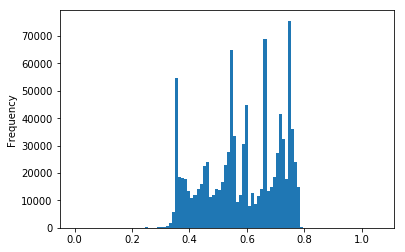

In [2]:
subs.dist1.plot.hist(bins=100)

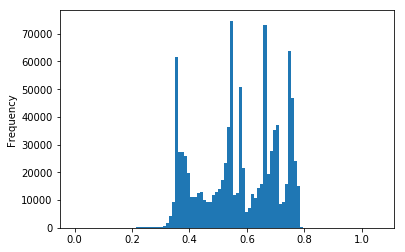

In [3]:
subs.dist2.plot.hist(bins=100)

# Histogram of Small Distances to (0.25,0.75) and (0.75,0.25)

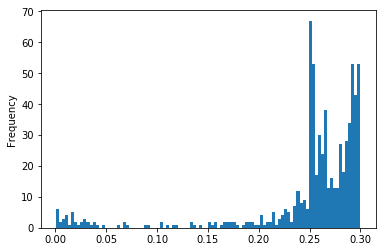

In [4]:
subs.dist1[subs.dist1<0.3].plot.hist(bins=100)

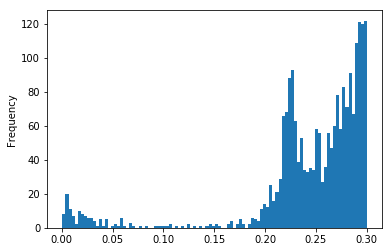

In [5]:
subs.dist2[subs.dist2<0.3].plot.hist(bins=100)